# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

Work done as part of the assignment is under **Lab 03 work** section.

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [1]:
import numpy as np
from matplotlib import pyplot

In [2]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [3]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

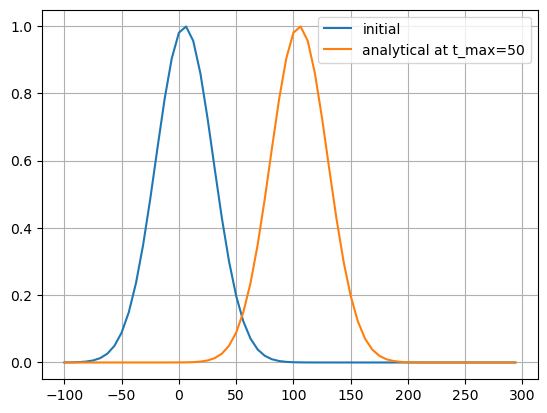

In [4]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [5]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __radd__(self, i): 
        return slice(i.start+1, i.stop+1)
    def __rsub__(self, i): 
        return slice(i.start-1, i.stop-1)

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [6]:
i = slice(1,nx-2)
one = shift()

nt = 50
dt = t_max / nt
C = u * dt / dx

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [7]:
psi = psi_0(x)
for _ in range(nt):
    psi[i] = psi[i] - (
        F(psi[i    ], psi[i+one], C) -
        F(psi[i-one], psi[i    ], C) 
    )

**7. comparing analytic and numerical solutions**

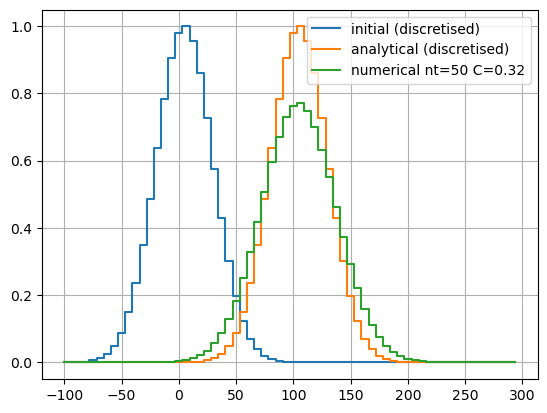

In [8]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

### Lab 03 work

The objective of this analysis is to study the convergence behavior of the upwind scheme for solving the advection equation. Convergence analysis helps us understand how numerical errors behave as we refine the spatial resolution (dx). The study ensures that the Courant number (**C**) remains fixed across simulations.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot

one = shift()

#### Error computation

The rmse_error() function calculates the root mean square error between the analytical and numerical solutions. This metric quantifies the average deviation of the numerical approximation from the exact solution:

In [42]:
def rmse_error(numeric, true_value):
    return np.sqrt(np.mean((numeric - true_value) ** 2))

A lower RMSE indicates a more accurate numerical solution.

In [ ]:
def upwind(psi, steps, courant, idx):
    for _ in range(steps):
        psi[idx] -= F(psi[idx], psi[idx + one], courant) - F(psi[idx - one], psi[idx], courant)
    return psi

In [18]:
def gaussian_profile(x, x0=5, amplitude=1, sigma=25):
    return amplitude * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

#### Simulation

The run_experiment() function iterates over a set of Courant numbers, and for each constant Courant number it iterates over the range of dx values (0.05, 0.15, ..., 3.95). For each dx, the function:

- Computes the corresponding time step dt = C * dx / velocity.

- Generates a spatial grid X ranging from -100 to 300.

- Computes the number of time steps (steps = time_span / dt).

- Runs the upwind scheme simulation.

- Computes the RMSE between the numerical and analytical solutions.

In [58]:
def run_experiment(velocity, time_span, courant_values):
    results = {}
    for courant in courant_values:
        dx_values, errors = [], []
        dx = -0.05
        for _ in range(40):
            dx += 0.1
            dt = courant * dx / velocity
            X = np.arange(-100, 300, dx)
            n = len(X)
            steps = int(time_span / dt)
            numerical = upwind(gaussian_profile(X), steps, courant, slice(1, n - 2))
            analytical = gaussian_profile(X - velocity * time_span)
            dx_values.append(dx)
            errors.append(rmse_error(analytical, numerical))
        results[courant] = (dx_values, errors)
    return results


courant_values = np.arange(0.05, 1, 0.15)

results = run_experiment(velocity=4, time_span=50, courant_values=courant_values)

#### Plotting the results

The plot_results() function visualizes how the error changes with dx for different Courant numbers:

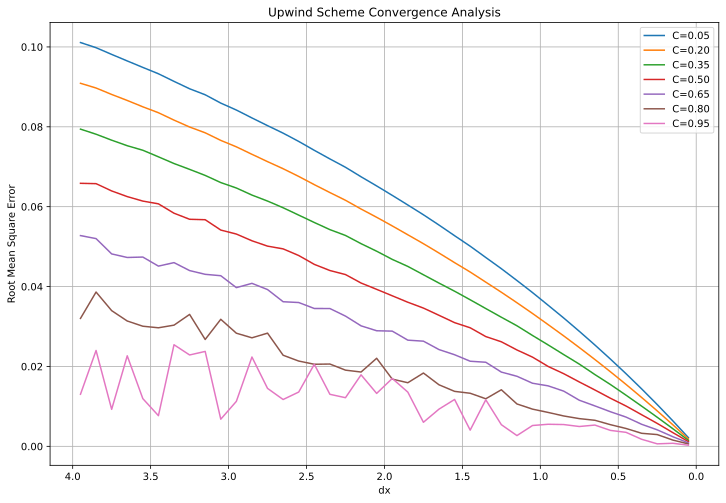

In [62]:
def plot_results(results):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca()

    ax.set_xticks(np.arange(0.0, 10.5, 0.5))
    ax.invert_xaxis()

    for courant, (dx_values, errors) in results.items():
        plt.plot(dx_values, errors, label=f"C={courant:.2f}")
    
    plt.legend()
    plt.xlabel("dx")
    plt.ylabel("Root Mean Square Error")
    plt.title("Upwind Scheme Convergence Analysis")
    plt.grid()

    show_plot(fig=fig)

plot_results(results)

The x-axis represents dx (grid resolution), and the y-axis represents the RMSE error, illustrating how increasing resolution improves accuracy.

We can plot it similarly with log-log plot:

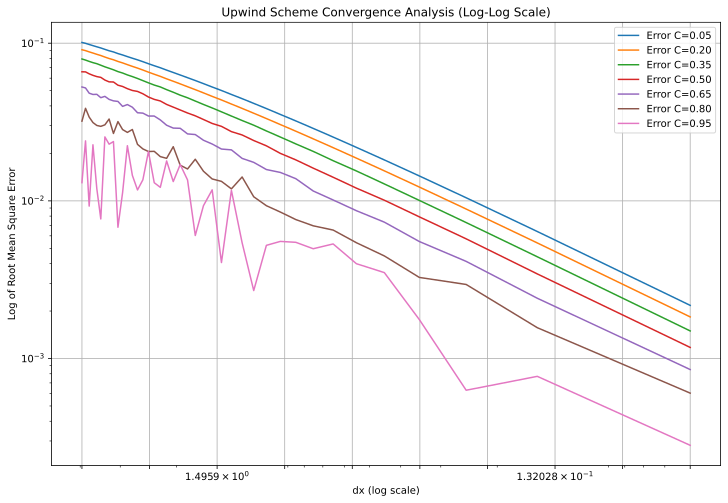

In [61]:
def logaritmic_plot_results(results):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca()

    # Logarithmic scale for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.invert_xaxis()

    # Adjust x-ticks based on the range of dx values
    all_dx_values = [dx for dxs, _ in results.values() for dx in dxs] 
    min_dx, max_dx = np.min(all_dx_values), np.max(all_dx_values)

    # Set x-ticks to cover the range of dx values
    ax.set_xticks(np.logspace(np.log10(min_dx), np.log10(max_dx), num=10))

    # Plot the data
    for courant, (dx_values, errors) in results.items():
        plt.plot(dx_values, errors, label=f"Error C={courant:.2f}")

    plt.legend()
    plt.xlabel("dx (log scale)")
    plt.ylabel("Log of Root Mean Square Error")
    plt.title("Upwind Scheme Convergence Analysis (Log-Log Scale)")
    plt.grid()

    show_plot(fig=fig)

logaritmic_plot_results(results)


#### Conclusions

The results highlight that decreasing dx generally reduces error, confirming the convergence of the upwind scheme. <br>

However, the rate of convergence also depends on the Courant number - we can observe that for higher Courant number RMSE is smaller. Keeping that in mind, the tendency for every Courant number is the same - it decreases for smaller dx. Another thing to point out from the chart is that for C value closer to 1, the variance of RMSE for small dx is big.

It can be observed that for very small dx values, the RMSE reduces significantly, but this comes with the cost of increased computational resources. The results also show that even though finer grids lead to smaller errors, diminishing returns can be seen beyond a certain dx resolution. This suggests that there is an optimal grid size, beyond which further refinement doesn't lead to a notable improvement in accuracy.

This analysis is crucial for choosing the optimal balance between accuracy and computational cost when using the upwind method for solving advection equations.